In [1]:
import itertools
import pathlib
import pickle
import sys
import warnings
import shapely
import matplotlib.colors as mcl

import astropy.units as u
import brutus
import brutus.seds
import brutus.utils
import astropy.coordinates as coords
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.cm as cm
import numpy as np
import torch as xp
import torch.optim as optim
import torch.utils.data as td
from astropy.coordinates import Distance, SphericalRepresentation
from astropy.table import QTable
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.flows.base import Flow
from nflows.nn.nets import ResidualNet
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from torch import nn
from tqdm import tqdm

# isort: split
import stream_ml.pytorch as sml
import stream_ml.visualization as smlvis
from stream_ml.pytorch.params import ModelParameter, ModelParameters
from stream_ml.pytorch.params.bounds import ClippedBounds, SigmoidBounds
from stream_ml.pytorch.params.scaler import StandardLocation, StandardLnWidth
from stream_ml.pytorch.builtin import Parallax2DistMod
from stream_ml.visualization.background import \
    exponential_like_distribution as exp_distr
from stream_ml.core.builtin._stats.trunc_skewnorm import logpdf

# isort: split
from helper import isochrone_spline

sys.path.append(pathlib.Path().resolve().parents[0].as_posix())
# isort: split

from chenab_frame import ChenabFrame

/home/jupyter-nstarman/.conda/envs/sml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder = pathlib.Path(".") / "figures" / "model_Chenab-iso-(g-r)"
folder.mkdir(parents=True, exist_ok=True)

In [3]:
DATA = pathlib.Path("/home/jupyter-comack/stream_ml/Chenab/data/").resolve()
DATA

PosixPath('/home/jupyter-comack/stream_ml/Chenab/data')

In [4]:
rng = np.random.default_rng()
rng

Generator(PCG64) at 0x7F8C23FD75A0

In [5]:
chenab_frame = ChenabFrame()

### Loading in Data

In [6]:
# Read full tables
chenab_data = QTable.read(DATA / "s5cat_dr3_5.fits")

# make phi1, phi2
chenab_c = coords.ICRS(
    ra=chenab_data['ra'],
    dec=chenab_data['dec'],
    radial_velocity=chenab_data['vel_calib']*u.km/u.s
).transform_to(chenab_frame)

chenab_data['phi1'] = chenab_c.phi1.to_value(u.deg)
chenab_data['phi2'] = chenab_c.phi2.to_value(u.deg)

# Select down to chenab fields
aau_sel = (  ((chenab_data['phi1'] > -75) & (chenab_data['phi1'] < 75))
           & ((chenab_data['phi2'] > -3) & (chenab_data['phi2'] < 3)))

chenab_data = chenab_data[aau_sel]
chenab_c = chenab_c[aau_sel]

# fix bad values in g, r
chenab_data["decam_g"][chenab_data["decam_g"] < -90 * u.mag] = np.nan
chenab_data["decam_r"][chenab_data["decam_r"] < -90 * u.mag] = np.nan

# sort by phi1 
chenab_data = chenab_data[np.argsort(chenab_data["phi1"])]

In [7]:
li_mem = QTable.read(DATA / "aaumembers.dat", format='ascii')
li_mem = li_mem[li_mem['AAU_mem_prob'] > 0.9]
li_mem_c = coords.ICRS(
    ra=li_mem['ra'] * u.deg,
    dec=li_mem['dec'] * u.deg,
    radial_velocity=li_mem['vel_calib'] * u.km / u.s
).transform_to(chenab_frame)
li_mem['phi1'] = li_mem_c.phi1.to_value(u.deg)
li_mem['phi2'] = li_mem_c.phi2.to_value(u.deg)

chenab_data["phi2_error"] = 1e-6 * u.deg

In [8]:
# mdl_mem = QTable.read("model_mem_list.dat", format='ascii.ecsv')
# mdl_mem_c = coords.ICRS(
#     ra=mdl_mem['ra'],
#     dec=mdl_mem['dec'],
#     radial_velocity=mdl_mem['vel_calib']*u.km/u.s
# ).transform_to(atlas_frame)
# mdl_mem['phi1'] = mdl_mem_c.phi1.to_value(u.deg)
# mdl_mem['phi2'] = mdl_mem_c.phi2.to_value(u.deg)
# mdl_mem["phi2_error"] = 1e-6 * u.deg

In [9]:
# bhb_mem = QTable.read(DATA / "bhb.dat", format='ascii.ecsv')
# bhb_mem_c = coords.ICRS(
#     ra=bhb_mem['ra'],
#     dec=bhb_mem['dec']
# ).transform_to(atlas_frame)
# bhb_mem['phi1'] = bhb_mem_c.phi1.to_value(u.deg)
# bhb_mem['phi2'] = bhb_mem_c.phi2.to_value(u.deg)
# bhb_mem["phi2_error"] = 1e-6 * u.deg
# bhb_mem['distmod_est'] = 16.67 - 0.034*bhb_mem['phi1']

# bhb_mem.sort('phi1')

In [7]:
# Data cuts
quality_cuts = (
      (atlas_data["good_star"] == 1)
    & (np.isnan(atlas_data['feh50']) | (atlas_data['feh50'] < -1.5))
    & (np.isnan(atlas_data['vgsr']) | ((-350 * u.km/u.s < atlas_data['vgsr']) & (atlas_data['vgsr'] < 150 * u.km/u.s)))
    & (np.isnan(atlas_data['pmra']) | ((-5 * u.mas/u.yr < atlas_data['pmra']) & (atlas_data['pmra'] < 5 * u.mas/u.yr)))
    & (np.isnan(atlas_data['pmdec']) | ((-4 * u.mas/u.yr < atlas_data['pmdec']) & (atlas_data['pmdec'] < 4 * u.mas/u.yr)))
)

atlas_data_red = (atlas_data[quality_cuts]).copy()
len(atlas_data_red)

NameError: name 'atlas_data' is not defined

In [11]:
table_astrometric_names = ("phi2", "vgsr", "pmra", "pmdec")
table_astrometric_err_names = ("phi2_error", "vel_calib_std", "pmra_error", "pmdec_error")
table_photometric_names = ("decam_g", "decam_r")
table_photometric_err_names = ()  # TODO
table_metal_names = ("feh50",)
table_metal_err_names = ("feh_std",)
table_names = (
    ("phi1",)
    + tuple(item for pair in zip(table_astrometric_names, table_astrometric_err_names) for item in pair)
    + tuple(item for pair in zip(table_metal_names, table_metal_err_names) for item in pair)
    + table_photometric_names  # table_photometric_err_names
)

renamer = {
    "phi2": "phi2", "phi2_error": "phi2_err",
    "pmra": "pmra", "pmra_error": "pmra_err",
    "pmdec": "pmdec", "pmdec_error": "pmdec_err",
    "pmphi1": "pmphi1", "pmphi1_error": "pmphi1_err",
    "pmphi2": "pmphi2", "pmphi2_error": "pmphi2_err",
    "vgsr": "rv", "vel_calib_std": "rv_err",
    "decam_g": "g", "decam_r": 'r', "parallax": "parallax",
    "distmod": "distmod", "feh50" : "feh", "feh_std": "feh_err",
}

data_real = sml.Data.from_format(
    chenab_data_red,
    fmt="astropy.table",
    names=table_names,
    renamer=renamer,
)

data = data_real.astype(xp.Tensor, dtype=xp.float32)


# rescale
scaler = sml.utils.StandardScaler.fit(data, names=data.names)

where = sml.Data(
    ~xp.isnan(data.array),  # True where NOT missing
    names=data.names,
)

# Set NaN to median value
data.array[~where.array] = xp.asarray(
    np.repeat(np.nanmedian(data.array, axis=0, keepdims=True),
              len(data), axis=0)[~where.array])

data_real.array[~where.array] = np.repeat(np.nanmedian(data.array, axis=0, keepdims=True), len(data), axis=0)[~where.array]

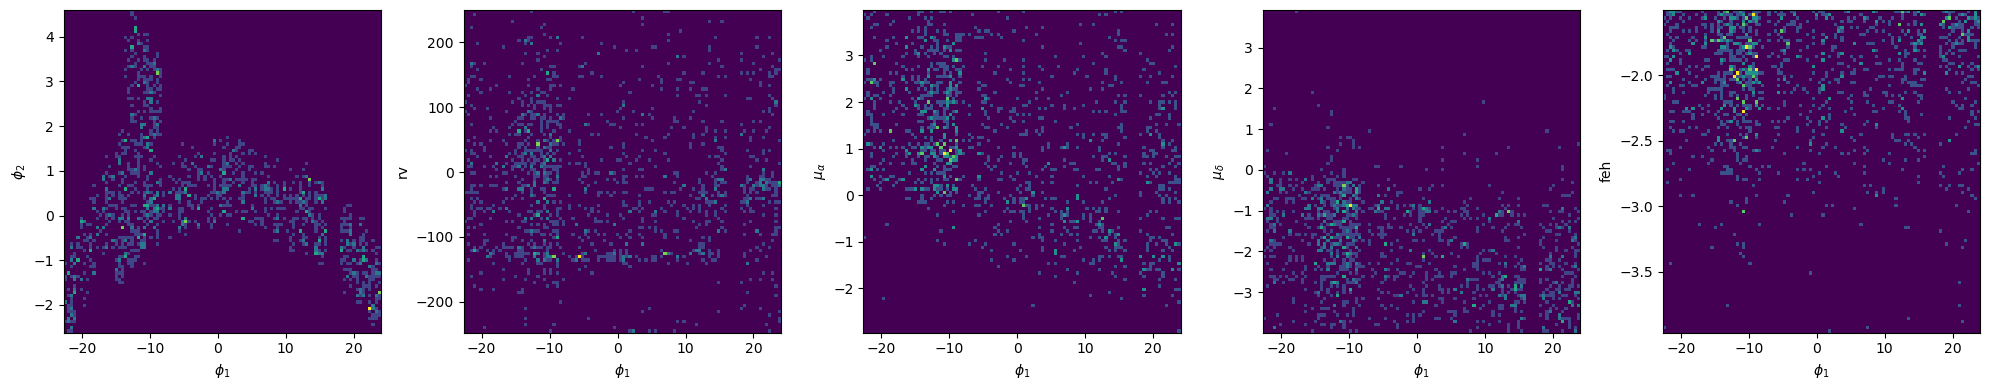

In [12]:
smlvis.coord_panels(
    data_real,
    coords=("phi2", "rv", "pmra", "pmdec", "feh"),
    use_hist=True,
    savefig=str(folder / "selection.png"),
)
plt.show();

### Building Isochrone

In [13]:
iso_drt = QTable.read(DATA / "atlas_dartmouth_11-5.dat", format='ascii.ecsv')

# manual adjustments
iso_drt['g'] = iso_drt['g'] + 0.088
iso_drt['r'] = iso_drt['r'] + 0.058

iso_drt['g-r'] = (iso_drt['g'])-(iso_drt['r'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


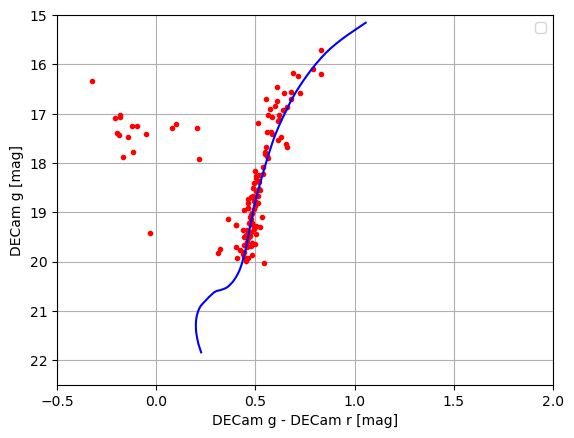

In [14]:
plt.plot(mdl_mem['decam_g']-mdl_mem['decam_r'], mdl_mem['decam_g'], c="red", marker='.', linestyle='none', alpha=1)
plt.plot(((iso_drt['g'])-(iso_drt['r']))[100:], (iso_drt['g']+17.1)[100:], c="blue")

plt.xlim(-0.5, 2)
plt.ylim((22.5, 15))
plt.grid(True)
plt.legend()
plt.xlabel('DECam g - DECam r [mag]')
plt.ylabel('DECam g [mag]')
plt.show();

## Defining Model

In [15]:
coord_astrometric_names = ("phi2", "rv", "pmra", "pmdec")
coord_astrometric_err_names = ("phi2_err", "rv_err", "pmra_err", "pmdec_err")
coord_photometric_names = ("g", "r")
coord_photometric_err_names = ("g_err", "r_err")

coord_names = coord_astrometric_names + coord_photometric_names

In [16]:
coord_bounds: dict[str, tuple[float, float]] = {
    k: (float(np.nanmin(data_real[k])), float(np.nanmax(data_real[k])))
    for k in coord_names
}

# make subselections
coord_astrometric_bounds = {k: coord_bounds[k] for k in coord_astrometric_names}
coord_photometric_bounds = {k: coord_bounds[k] for k in coord_photometric_names}

coord_bounds

{'phi2': (-2.6216100622361753, 4.598304777168021),
 'rv': (-247.6231033938883, 249.99681946071019),
 'pmra': (-2.952738239135585, 3.9751028539987727),
 'pmdec': (-3.997425139607703, 3.924411315003752),
 'g': (14.759774208068848, 20.260440826416016),
 'r': (14.881896018981934, 20.016958236694336)}

### Background Model

In [17]:
background_astrometric_model = sml.builtin.TruncatedSkewNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=3 * len(coord_astrometric_names), dropout=0.15),
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["phi2"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["rv"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(4, 5),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmra"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(0.1, 0.7),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(*coord_bounds["pmdec"]),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-0.1, 0.35),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "skew": ModelParameter(
                    bounds=SigmoidBounds(0.1, 1),
                    scaler=None,
                ),
            },
        }
    ),
    require_where=True
)

Background Flow

In [18]:
# Background
off_stream = (
    ((data["rv"] > -100) | (data["rv"] < -150))
    & where["g", "r"].array.all(-1)  # no NaN
)

(-25.0, 25.0)

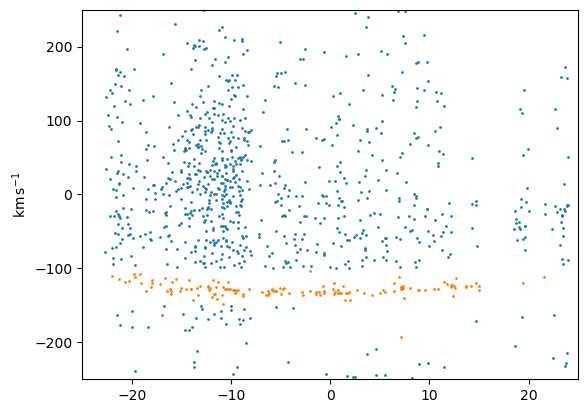

In [19]:
plt.scatter(data['phi1'][off_stream], data['rv'][off_stream], s=1)
plt.scatter(mdl_mem['phi1'], mdl_mem['vgsr'], s=1)
plt.ylim((-250, 250))
plt.xlim((-25, 25))

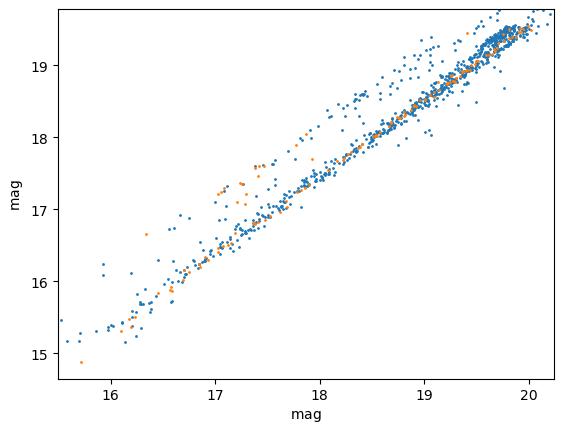

In [20]:
plt.scatter(data['g'][off_stream], data['r'][off_stream], s=1)
plt.scatter(mdl_mem['decam_g'], mdl_mem['decam_r'], s=1)

In [21]:
num_layers = 4
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=3, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow_coords = ("phi1",) + coord_photometric_names
flow_scaler = scaler[flow_coords]  # slice the StandardScaler

bkg_flow = sml.builtin.compat.FlowModel(
    net=Flow(transform, base_dist),
    jacobian_logdet=-xp.log(xp.prod(flow_scaler.scale[1:])),
    data_scaler=flow_scaler,
    coord_names=coord_photometric_names,
    coord_bounds=coord_photometric_bounds,
    params=ModelParameters(),
    require_where=True
)

In [22]:
torch_dataset = td.TensorDataset(data[flow_coords][off_stream].array,
                                 where[flow_coords][off_stream].array)
loader = td.DataLoader(dataset=torch_dataset, batch_size=200, shuffle=True, num_workers=0)
optimizer = optim.AdamW(bkg_flow.parameters(), lr=1e-3)

EPOCHS = 1_000

(folder / "flow").mkdir(exist_ok=True, parents=True)
bkg_flow.zero_grad()

for epoch in tqdm(range(EPOCHS)):

    for step, (data_cur, dat_where) in enumerate(loader):
        data_cur = sml.Data(data_cur, names=flow_coords)
        dat_where = sml.Data(dat_where, names=flow_coords)

        optimizer.zero_grad()
        mpars = bkg_flow.unpack_params(bkg_flow(data_cur))
        loss = - bkg_flow.ln_likelihood_tot(mpars, data_cur, where=dat_where,)

        loss.backward()
        optimizer.step()
        bkg_flow.zero_grad()

        if epoch % 50 == 0 or epoch == EPOCHS - 1:
            with xp.no_grad():
                mpars = bkg_flow.unpack_params(bkg_flow(data))
                lik = bkg_flow.likelihood(mpars, data, where=where,)

            fig, ax = plt.subplots()
            im = ax.scatter(data["g"]-data['r'], data["g"], s=1, c=lik)
            ax.set_xlim((-0.7,1.5))
            ax.set_ylim((21,14))
            plt.colorbar(im, ax=ax)
            fig.savefig(folder / "flow" / f"epoch_{epoch:05}.png")

            plt.close(fig)

            xp.save(bkg_flow.state_dict(), folder / "flow" / f"model_{epoch}.pt")

bkg_flow.load_state_dict(xp.load(folder / "flow" / f"model_{EPOCHS-1}.pt"))
object.__setattr__(bkg_flow, "with_grad", False)

100%|██████████| 1000/1000 [01:09<00:00, 14.44it/s]


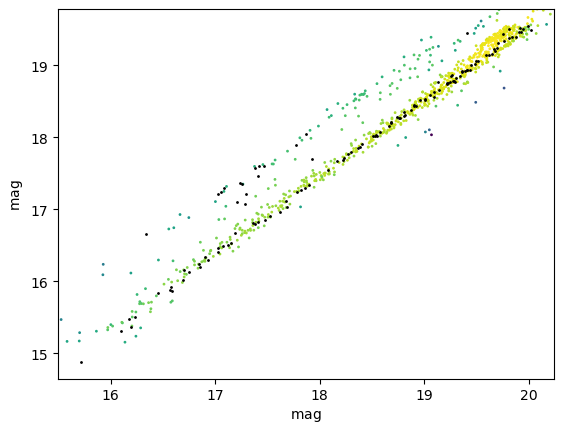

In [23]:
lik = bkg_flow.ln_likelihood(bkg_flow.unpack_params(bkg_flow(data)), data, where=where,)[off_stream]

plt.scatter(data['g'][off_stream], data['r'][off_stream], s=1, c=lik.numpy())
plt.scatter(mdl_mem['decam_g'], mdl_mem['decam_r'], s=1, c="k")

In [24]:
background_metal_model = sml.builtin.Exponential(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=16, n_layers=3, n_out=1, dropout=0.15),
    data_scaler=scaler,
    coord_names=("feh", ),
    coord_err_names=('feh_err',),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters({"feh": {"slope": ModelParameter(bounds=SigmoidBounds(-2.0, -1.0), scaler=None)}}),
)

In [25]:
background_model = sml.IndependentModels(
        {
        "astrometric": background_astrometric_model,
        "metal": background_metal_model,
        "photometric": bkg_flow,
    }
)

### Stream Model

In [26]:
stream_astrometric_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2 * len(coord_astrometric_names), dropout=0.15),
    data_scaler=scaler,
    coord_names=coord_astrometric_names,
    coord_err_names=coord_astrometric_err_names,
    coord_bounds=coord_astrometric_bounds,
    params=ModelParameters(
        {
            "phi2": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, 2.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "phi2", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "phi2", xp=xp),
                ),
            },
            "rv": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-145., 100.),
                    scaler=StandardLocation.from_data_scaler(scaler, "rv", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-3, 3),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "rv", xp=xp),
                ),
            },
            "pmra": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-1.4, 0.3),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmra", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.0),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmra", xp=xp),
                ),
            },
            "pmdec": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-2.0, -0.15),
                    scaler=StandardLocation.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-9, -1.2),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "pmdec", xp=xp),
                ),
            },
        }
    ),
    require_where=True
)

In [33]:
isochrone_spl = isochrone_spline(
    np.lib.recfunctions.structured_to_unstructured(iso_drt[['g', 'r']].as_array())[130:],
    xp=np
)

stream_abs_mags = np.lib.recfunctions.structured_to_unstructured(iso_drt[['g', 'r']].as_array())[130:]

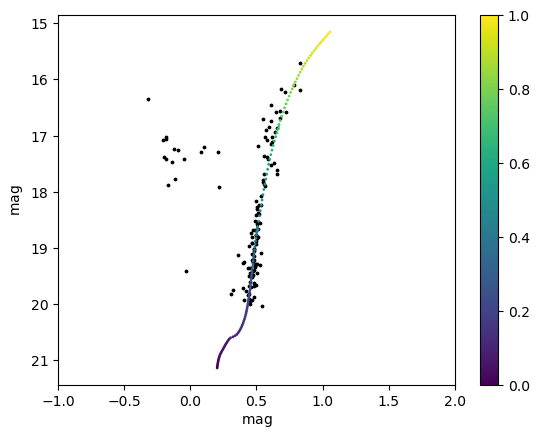

In [34]:
plt.scatter(mdl_mem["decam_g"] - mdl_mem['decam_r'],
            mdl_mem["decam_g"],
            s=3, c="k")
plt.scatter(stream_abs_mags[:,0] - stream_abs_mags[:,1],
            stream_abs_mags[:,0]+17.1,
            c=isochrone_spl.x, s=1)
plt.gca().invert_yaxis()
plt.xlim((-1.0,2))
plt.colorbar()

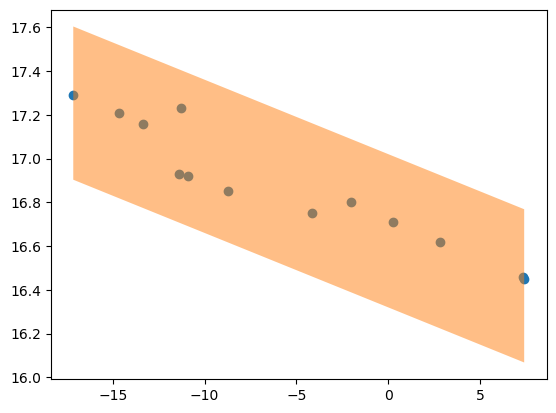

In [35]:
plt.scatter(bhb_mem['phi1'], bhb_mem['distmod'])
plt.fill_between(bhb_mem['phi1'], bhb_mem['distmod_est'] - bhb_mem['w_distmod'], bhb_mem['distmod_est'] + bhb_mem['w_distmod'], alpha=0.5)

In [36]:
# Selection of control points
stream_control_points = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("phi1", "distmod_est"), renamer={'distmod_est':"distmod"}).astype(xp.Tensor, dtype=xp.float32)

stream_control_widths = sml.Data.from_format(bhb_mem, fmt="astropy.table", names=("w_distmod",)).astype(xp.Tensor, dtype=xp.float32)
stream_control_widths = sml.Data(stream_control_widths.array, names=("distmod",))

stream_control_points_prior = sml.prior.ControlRegions(
    center=stream_control_points,
    lamda=10_000,
    width=stream_control_widths,
)

In [37]:
phot_names = ("g", "r",)
phot_bounds = {k: (float(np.nanmin(data[k])), float(np.nanmax(data[k]))) for k in phot_names}

stream_isochrone_model = sml.builtin.IsochroneMVNorm(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=2, dropout=0.15),
    data_scaler=scaler,
    # coordinates
    coord_names=('distmod',),
    coord_bounds={'distmod' : (14, 20),},
    # photometry
    phot_names=phot_names,
    phot_err_names=None,             #tuple(f"{k}_err" for k in phot_names),
    phot_apply_dm=(True, True),
    phot_bounds=phot_bounds,
    # isochrone
    gamma_edges=xp.linspace(isochrone_spl.x.min(), isochrone_spl.x.max(), 50),
    isochrone_spl=isochrone_spl,
    isochrone_err_spl=None,
#    stream_mass_function=...,
    # params
    params=ModelParameters({
        "distmod": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(10.0,21.0),
                    scaler=None,
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-5.0, 1.5),
                    scaler=None,
                ),
            },
        }
    ),
    priors=(stream_control_points_prior, ),
    require_where=True
)

In [38]:
stream_metal_model = sml.builtin.TruncatedNormal(
    net=sml.nn.lin_tanh(n_in=1, n_hidden=128, n_layers=5, n_out=2, dropout=0.15),
    data_scaler=scaler,
    coord_names=('feh',),
    coord_err_names=("feh_err",),
    coord_bounds={'feh' : (-6, 0),},
    params=ModelParameters(
        {
            "feh": {
                "mu": ModelParameter(
                    bounds=SigmoidBounds(-3.0, -1.0),
                    scaler=StandardLocation.from_data_scaler(scaler, "feh", xp=xp),
                ),
                "ln-sigma": ModelParameter(
                    bounds=SigmoidBounds(-1.0, 1),
                    scaler=StandardLnWidth.from_data_scaler(scaler, "feh", xp=xp),
                ),
            },
        }
    ),
    require_where=True
)

In [39]:
stream_model = sml.IndependentModels(
        {
        "astrometric": stream_astrometric_model,
        "photometric": stream_isochrone_model,
        "metal": stream_metal_model,
    },
)

### Combined Model

In [40]:
model = sml.MixtureModel(
    {
        "stream": stream_model,
        "background": background_model
    },
    net=sml.nn.lin_tanh(n_in=1, n_hidden=32, n_layers=4, n_out=1, dropout=0.15),
    data_scaler=scaler,
    params=ModelParameters(
        {
            "stream.weight": ModelParameter(
                bounds=SigmoidBounds(1e-2, 0.3), scaler=None
            ),
            "background.weight": ModelParameter(
                bounds=ClippedBounds(0.7, 1.0), scaler=None
            ),
        }
    ),
    priors=(
        sml.prior.HardThreshold(1, upper=-26, param_name="stream.weight", coord_name="phi1", data_scaler=scaler),
        sml.prior.HardThreshold(1, lower=26, param_name="stream.weight", coord_name="phi1", data_scaler=scaler),
    ),
)
model.components.keys()

frozen_dict_keys(['stream', 'background'])

In [41]:
EPOCHS = 20_000  # 5k w/out dropout, 10k with
BATCH_SIZE = int(len(data) * 0.075)

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

In [42]:
dataset = td.TensorDataset(
    data.array,  # data
    where.array,  # mask: TRUE where NOT missing
)

loader = td.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=True,  # drop rando last for better plotting
)

optimizer = optim.AdamW(
    list(model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1_250, eta_min=1e-5)

In [ ]:
(folder / "training").mkdir(parents=True, exist_ok=True)

slopes = np.full((EPOCHS // 100, len(coord_astrometric_names), BATCH_SIZE), np.nan)

num_steps = len(loader.dataset) // loader.batch_size
epoch: int = 0
for epoch in tqdm(range(EPOCHS)):

    for step, (step_arr, dat_where) in enumerate(loader):

        # Prepare
        step_data = sml.Data(step_arr, names=data.names)
        dat_where = sml.Data(dat_where, names=data.names)

        # Forward Step
        pred = model(step_data)
        if pred.isnan().any(): raise ValueError

        mpars = model.unpack_params(pred)
        loss_val = -model.ln_posterior_tot(
            mpars,
            step_data,
            where=dat_where,
        )

        # backward pass
        optimizer.zero_grad()
        loss_val.backward()

        # update weights
        optimizer.step()
        scheduler.step(epoch + step / num_steps)

        model.zero_grad()  # ?

    if epoch % 100 == 0 or epoch == EPOCHS - 1:
        model.eval()  # turn off training for nicer plot
        
        with xp.no_grad():
            mpars = model.unpack_params(model(data))

        fig = smlvis.astrometric_model_panels(
            model,
            data,
            mpars,
            coords=("phi2","rv", "pmra", "pmdec"),
            components=("stream.astrometric",),
            min_weight=1e-3,
            figsize=(12, 4),
            top_legend_fontsize=8,
            savefig=folder / "training" / f"epoch-{epoch:05}.png",
        )
        plt.close(fig)

        model.train()  # turn training back on

    # Serialize
    if epoch % 500 == 0 or epoch == EPOCHS - 1:
        xp.save(model.state_dict(), folder / "training" / f"model_{epoch:05}.pt")

# model.load_state_dict(xp.load(folder / "training" / f"model_{EPOCHS - 1:05}.pt"))

 66%|██████▋   | 13292/20000 [2:43:16<1:53:02,  1.01s/it]

## Plotting

In [43]:
# Get predictions
with xp.no_grad():
    mpars = model.unpack_params(model(data))
    stream_lnlik = model.component_ln_posterior("stream", mpars, data, where=where)

    tot_lnlik = model.ln_posterior(mpars, data, where=where)

stream_prob = np.exp(stream_lnlik - tot_lnlik)
print(stream_prob.min(), stream_prob.max())

tensor(0.) tensor(1.)


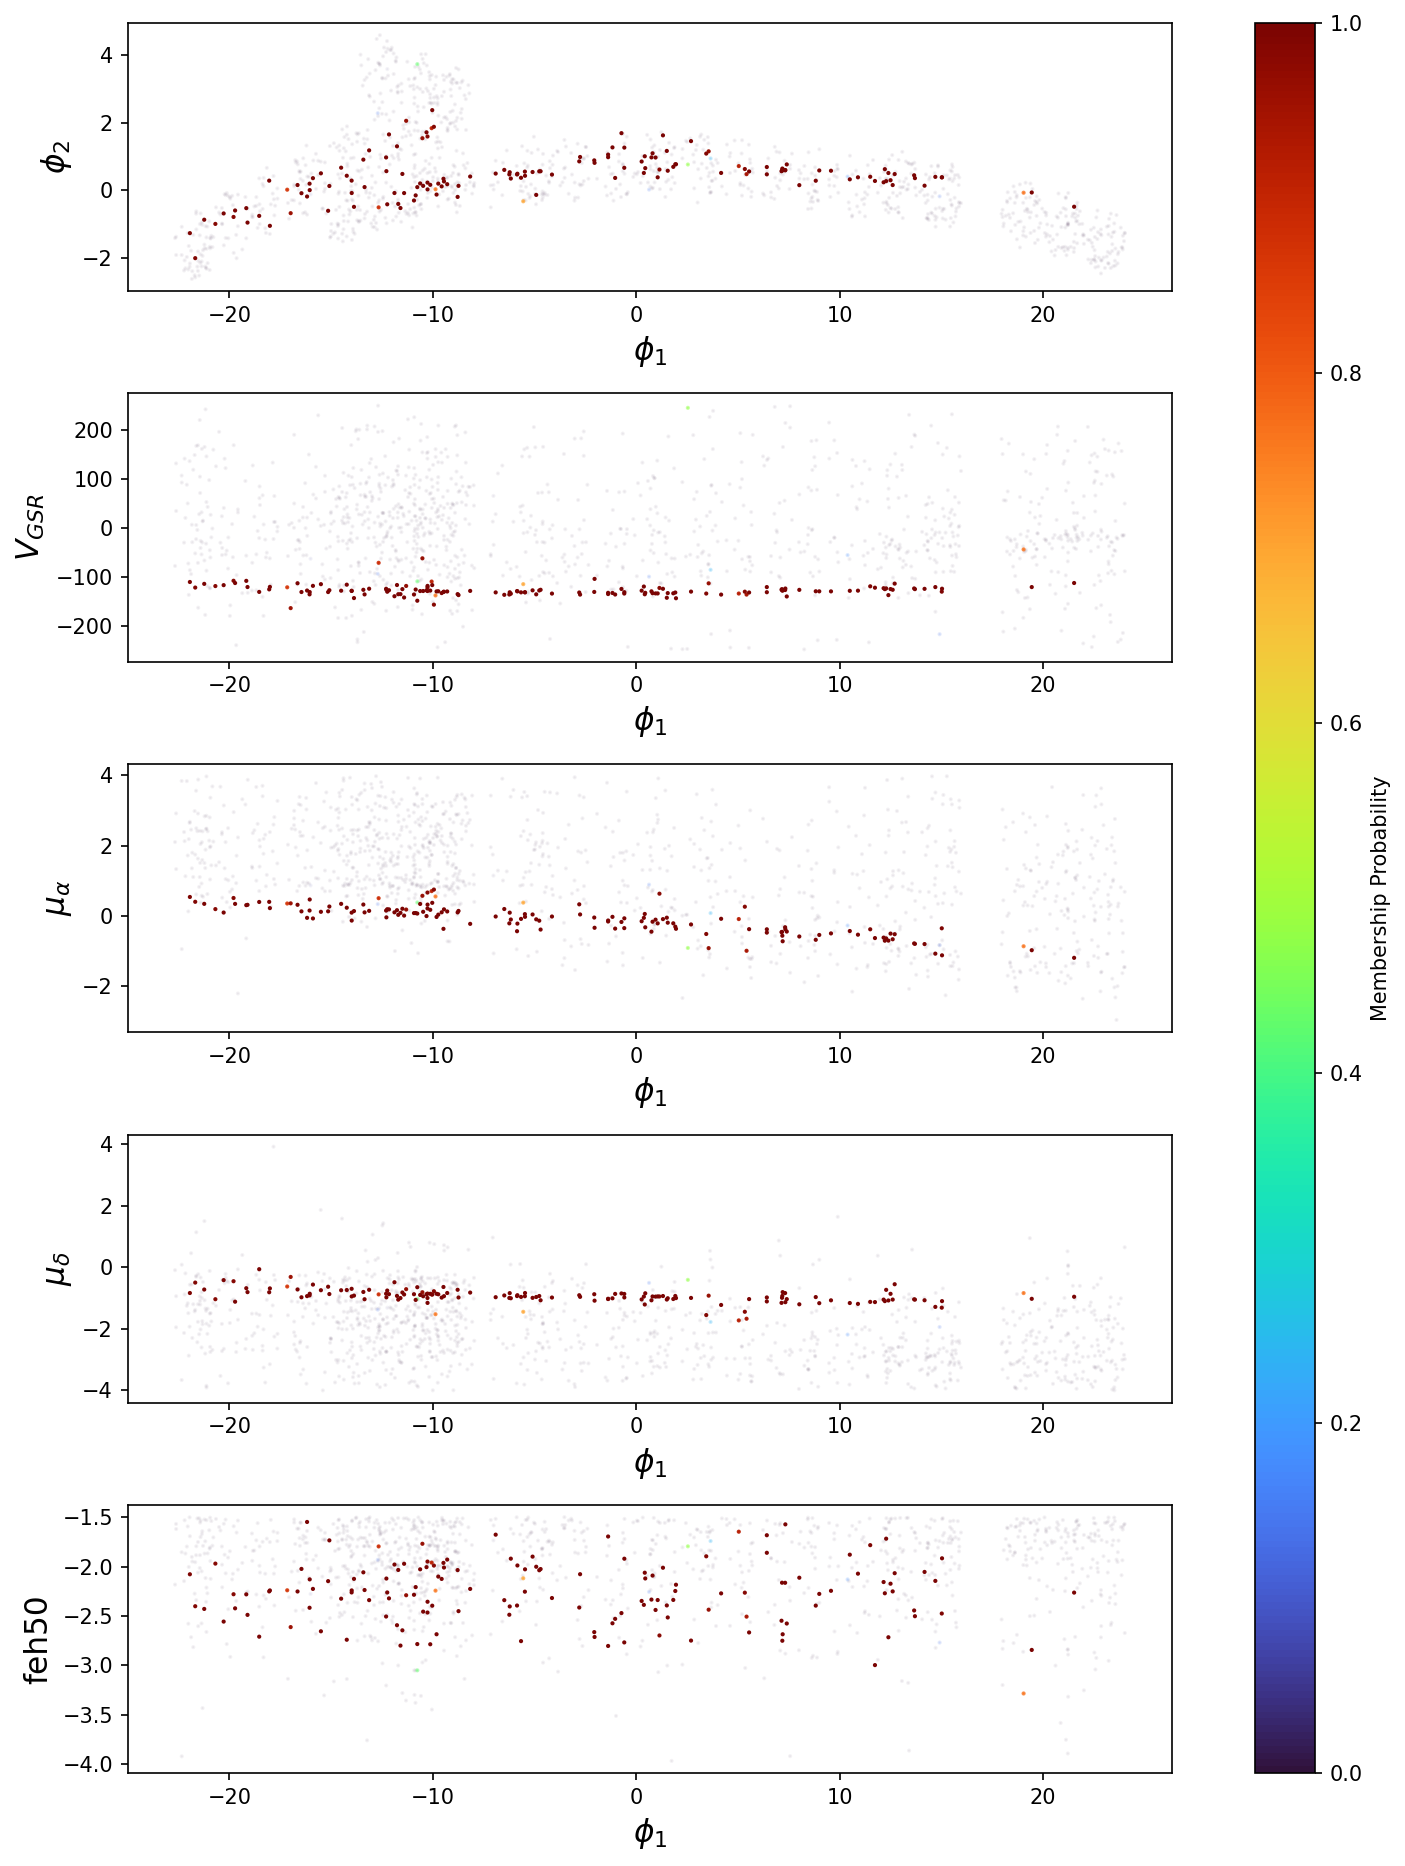

In [44]:
fig = smlvis.component_likelihood(
    atlas_data_red, 
    stream_prob,
    coords=("phi2", "vgsr", "pmra", "pmdec", "feh50"),
    savefig=folder / f"tot_stream_prob_all.pdf",
);
fig.set_dpi(150)
s1 = fig.get_axes()[0].scatter(atlas_data_red['phi1'], atlas_data_red['phi2'], c=stream_prob, cmap='turbo',  marker='.', alpha=1, label='ML Model Probable Members', visible=False)
gs2 = plt.GridSpec(1, 1, left=1.05, right=1.10, hspace=0.05, height_ratios=[0.1,])
ax4 = fig.add_subplot(gs2[0,0])
axs = fig.get_axes()
axs[1].set_ylabel('$V_{\t{GSR}}$')
fig.colorbar(s1, label='Membership Probability', cax=ax4, orientation='vertical')

In [45]:
test = atlas_data_red[stream_prob.numpy() > 0.95]

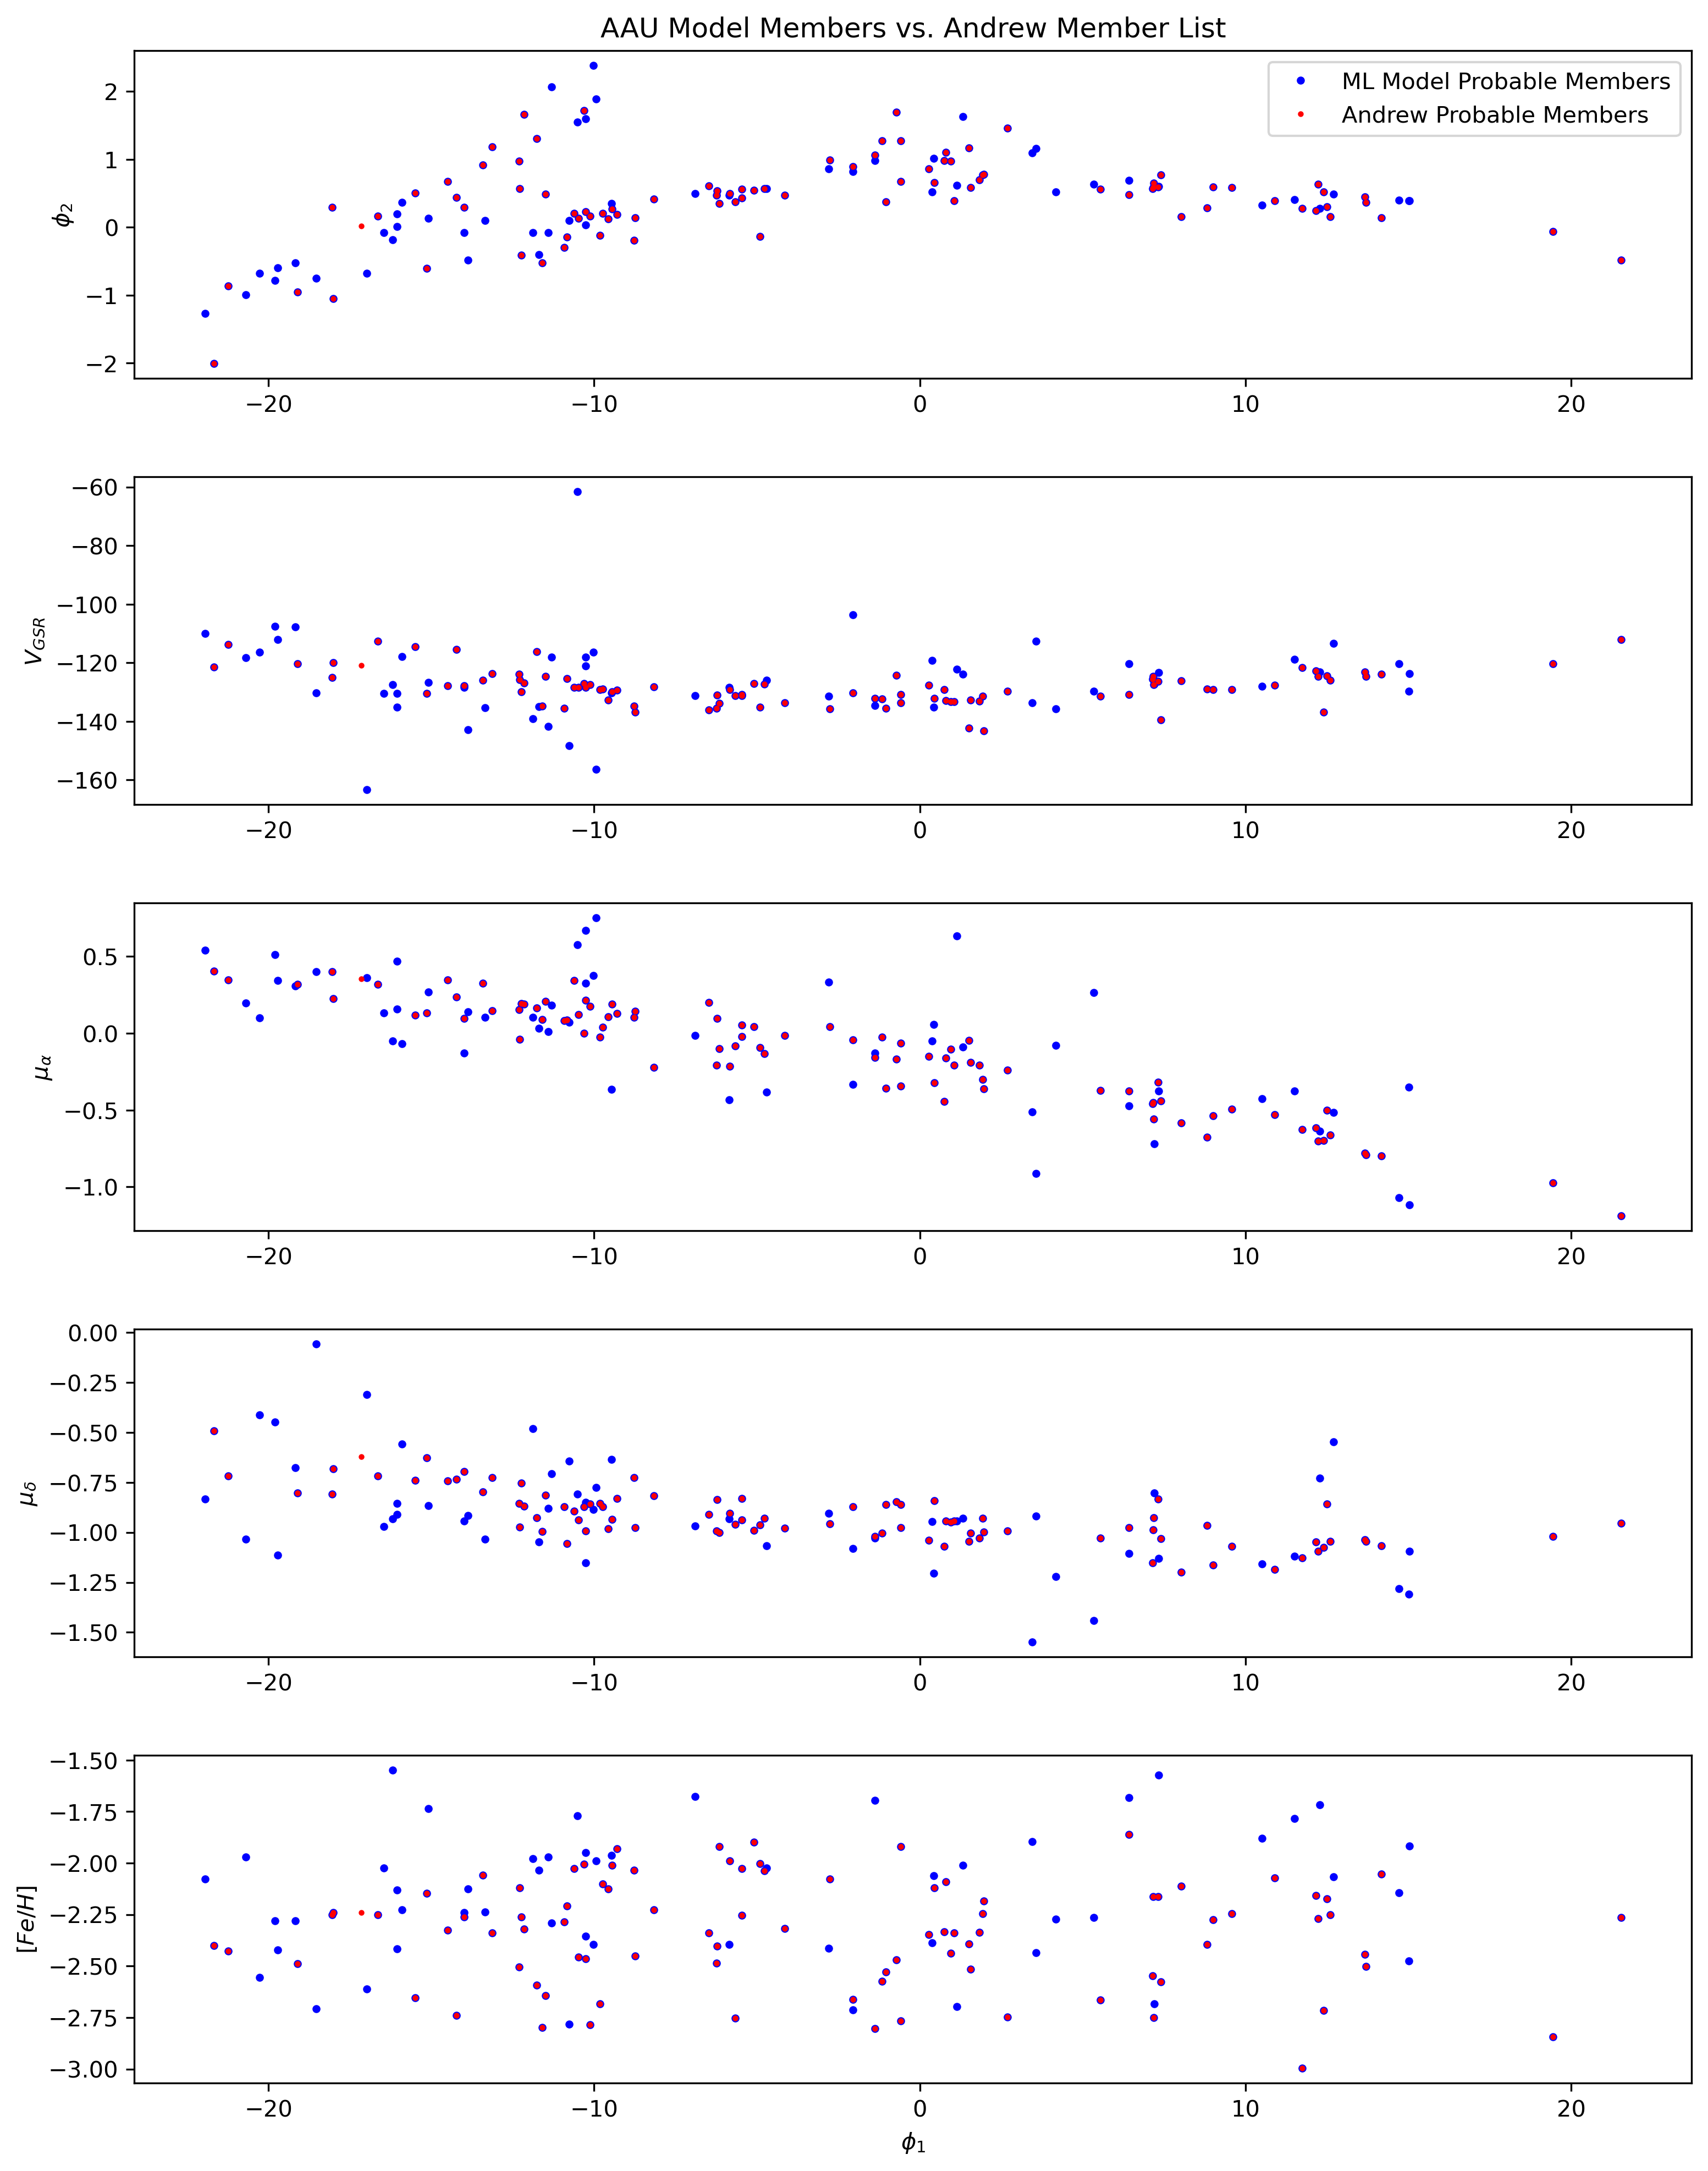

In [46]:
fig = plt.figure(dpi=300, figsize=(8,16))

gs1 = plt.GridSpec(5, 1, left=0.05, right=1.23, hspace=0.30)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[3,0])
ax5 = fig.add_subplot(gs1[4,0])

ax1.plot(test['phi1'], test['phi2'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5, label='ML Model Probable Members')
ax1.plot(li_mem['phi1'], li_mem['phi2'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3, label='Andrew Probable Members')

ax2.plot(test['phi1'], test['vgsr'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax2.plot(li_mem['phi1'], li_mem['vgsr'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax3.plot(test['phi1'], test['pmra'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax3.plot(li_mem['phi1'], li_mem['pmra'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax4.plot(test['phi1'], test['pmdec'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax4.plot(li_mem['phi1'], li_mem['pmdec'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)

ax5.plot(test['phi1'], test['feh50'],
         c="blue", marker='.', linestyle='none', alpha=1, ms=5)
ax5.plot(li_mem['phi1'], li_mem['feh50'],
         c="red", marker='.', linestyle='none', alpha=1, ms=3)


# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\\mu_{\\alpha}$')
ax4.set_ylabel('$\\mu_{\\delta}$')
ax5.set_ylabel('$[Fe/H]$')
ax5.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model Members vs. Andrew Member List')
ax1.legend()

In [47]:
outp = []
for val in test['phi2']:
    idx2 = np.where(atlas_data_red['phi2'] == val)[0][0]
    idx2 = int(idx2)
    outp.append(idx2)
outp = np.array(outp)

In [48]:
model.train()
phi2_samples_mu = []
rv_samples_mu = []
pmra_samples_mu = []
pmdec_samples_mu = []

phi2_samples_sigma = []
rv_samples_sigma = []
pmra_samples_sigma = []
pmdec_samples_sigma = []
with xp.no_grad():
    for i in range(100):
        mpars = model.unpack_params(model(data))
        phi2_samples_mu.append(mpars['stream.astrometric.phi2', 'mu'])
        rv_samples_mu.append(mpars['stream.astrometric.rv', 'mu'])
        pmra_samples_mu.append(mpars['stream.astrometric.pmra', 'mu'])
        pmdec_samples_mu.append(mpars['stream.astrometric.pmdec', 'mu'])
        
        phi2_samples_sigma.append(mpars['stream.astrometric.phi2', 'ln-sigma'])
        rv_samples_sigma.append(mpars['stream.astrometric.rv', 'ln-sigma'])
        pmra_samples_sigma.append(mpars['stream.astrometric.pmra', 'ln-sigma'])
        pmdec_samples_sigma.append(mpars['stream.astrometric.pmdec', 'ln-sigma'])

        
abce = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    abce.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
abce = np.array(abce)

In [49]:
model.eval()
with xp.no_grad():
    mpars = model.unpack_params(model(data))

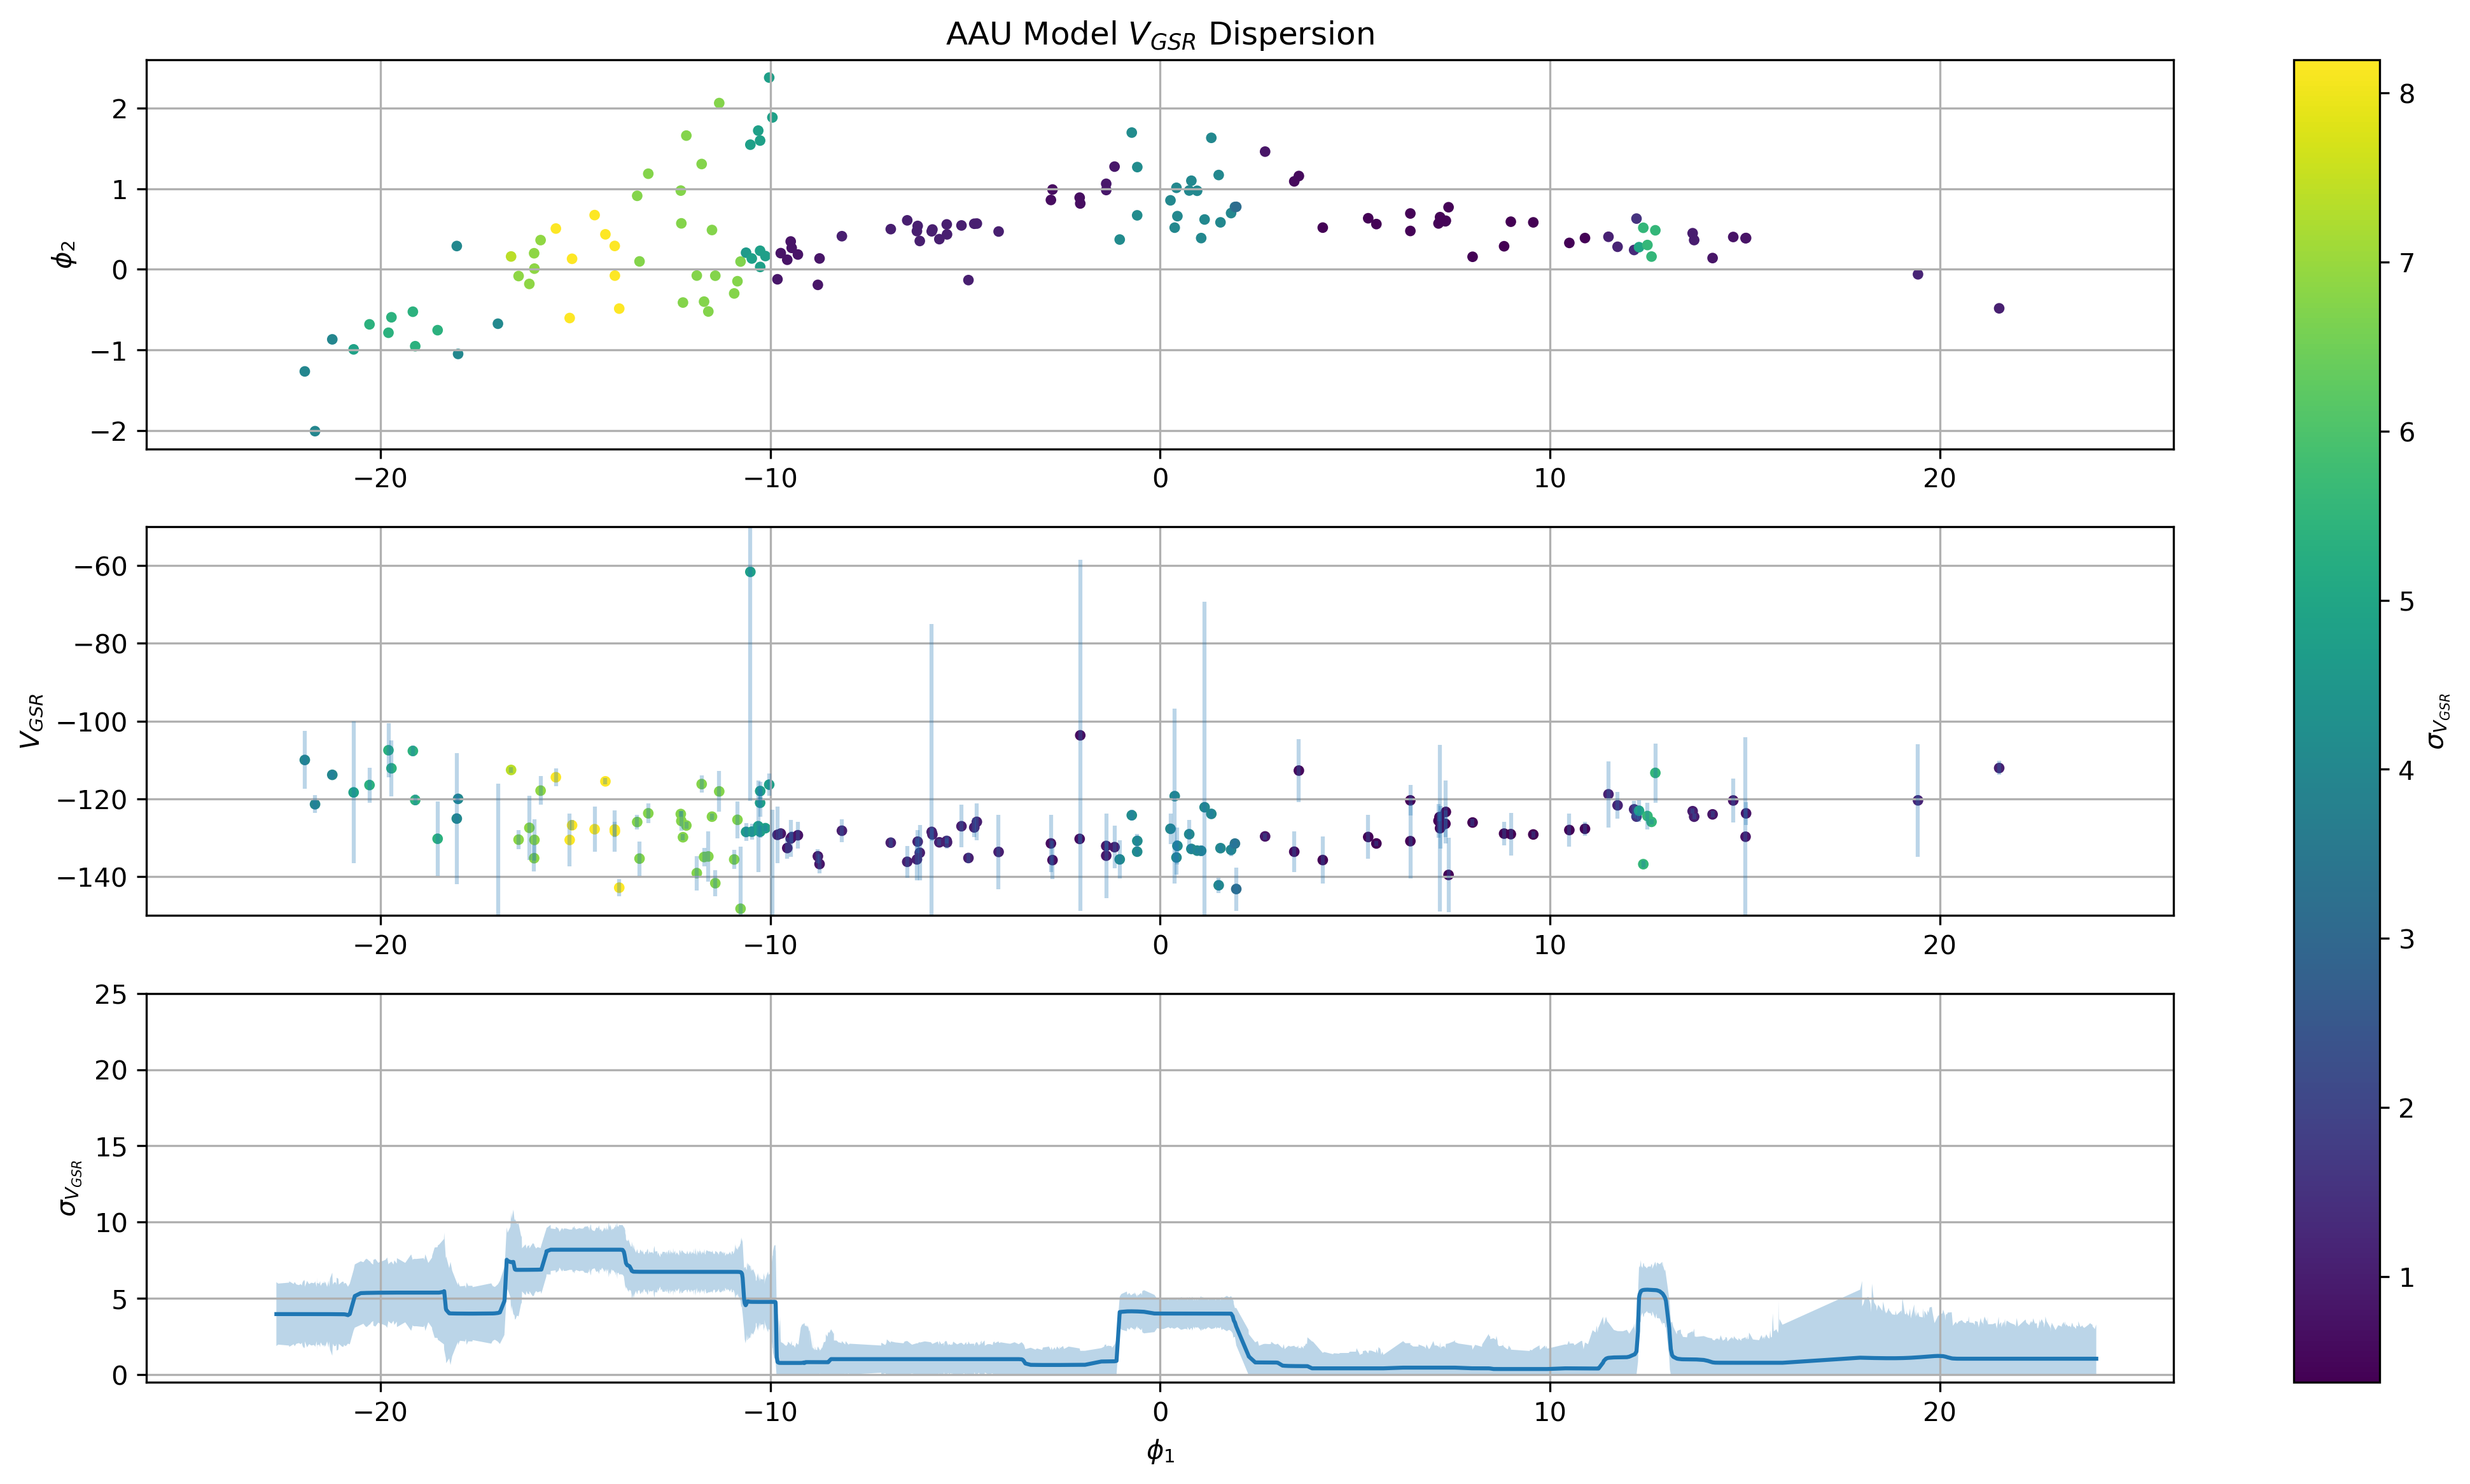

In [50]:
# Plot Setup
fig = plt.figure(dpi=300, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$V_{\t{GSR}}$')
ax3.set_ylabel('$\sigma_{V_{\t{GSR}}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $V_{\t{GSR}}$ Dispersion')

# Plotting
t1 = ax1.scatter(test['phi1'], test['phi2'], c=np.exp(mpars['stream.astrometric.rv', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test['phi1'], test['vgsr'], c=np.exp(mpars['stream.astrometric.rv', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(test['phi1'].value, test['vgsr'].value, yerr=test['vel_calib_std'].value, fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']))
fig.colorbar(t1, label='$\sigma_{V_{\t{GSR}}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream.astrometric.rv', 'ln-sigma'])-0.5*abce
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream.astrometric.rv', 'ln-sigma'])+0.5*abce, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-26,26))
ax2.set_xlim((-26,26))
ax3.set_xlim((-26,26))
ax2.set_ylim((-150,-50))
ax3.set_ylim((-0.5,25))
ax1.grid()
ax2.grid()
ax3.grid()


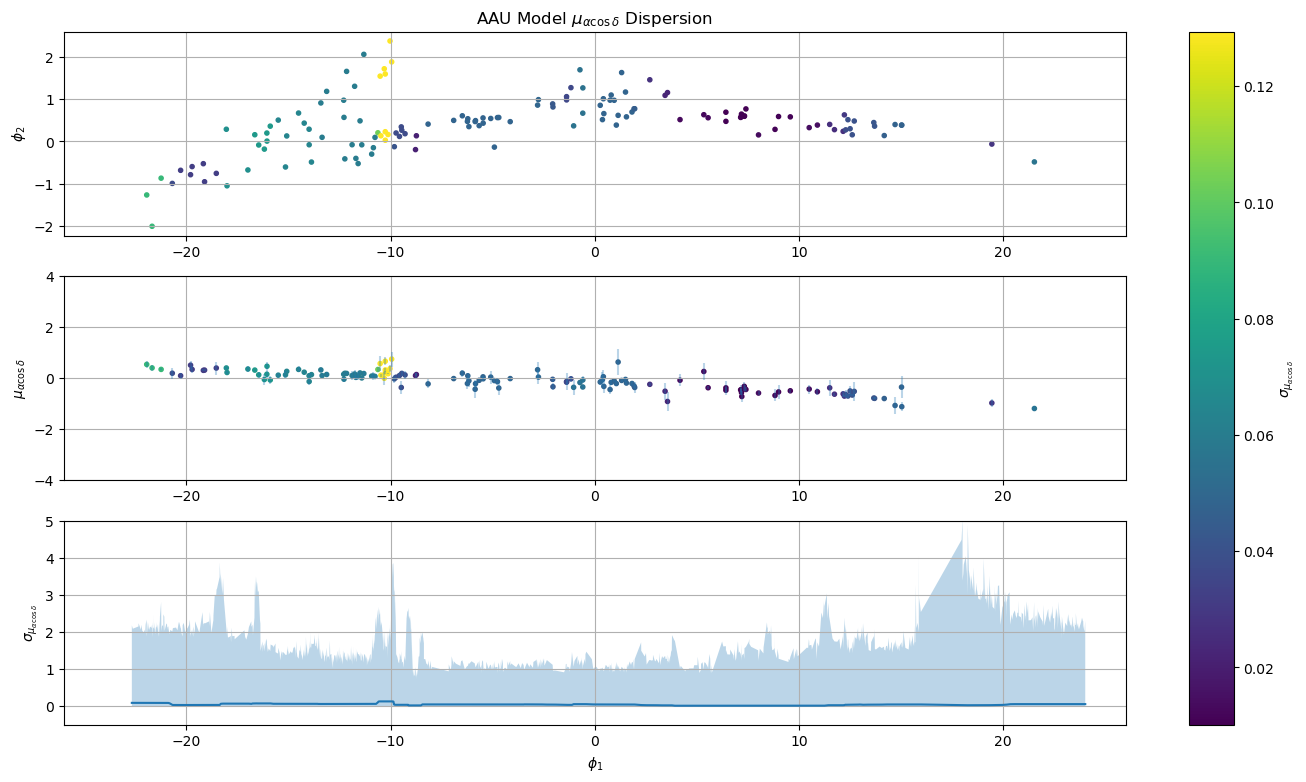

In [51]:
samples_2 = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    samples_2.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
samples_2 = np.array(samples_2)


# Plot Setup
fig = plt.figure(dpi=100, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$\\mu_{\\alpha\\cos\\delta}$')
ax3.set_ylabel('$\\sigma_{\\mu_{\\alpha\\cos\\delta}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $\\mu_{\\alpha\\cos\\delta}$ Dispersion')

# Plotting
t1 = ax1.scatter(test['phi1'], test['phi2'], c=np.exp(mpars['stream.astrometric.pmra', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test['phi1'], test['pmra'], c=np.exp(mpars['stream.astrometric.pmra', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(test['phi1'].value, test['pmra'].value, yerr=test['pmra_error'].value, fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.pmra', 'ln-sigma']))
fig.colorbar(t1, label='$\\sigma_{\\mu_{\\alpha\\cos\\delta}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream.astrometric.pmra', 'ln-sigma'])-0.5*samples_2
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream.astrometric.pmra', 'ln-sigma'])+0.5*samples_2, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-26,26))
ax2.set_xlim((-26,26))
ax3.set_xlim((-26,26))
ax2.set_ylim((-4,4))
ax3.set_ylim((-0.5,5))
ax1.grid()
ax2.grid()
ax3.grid()

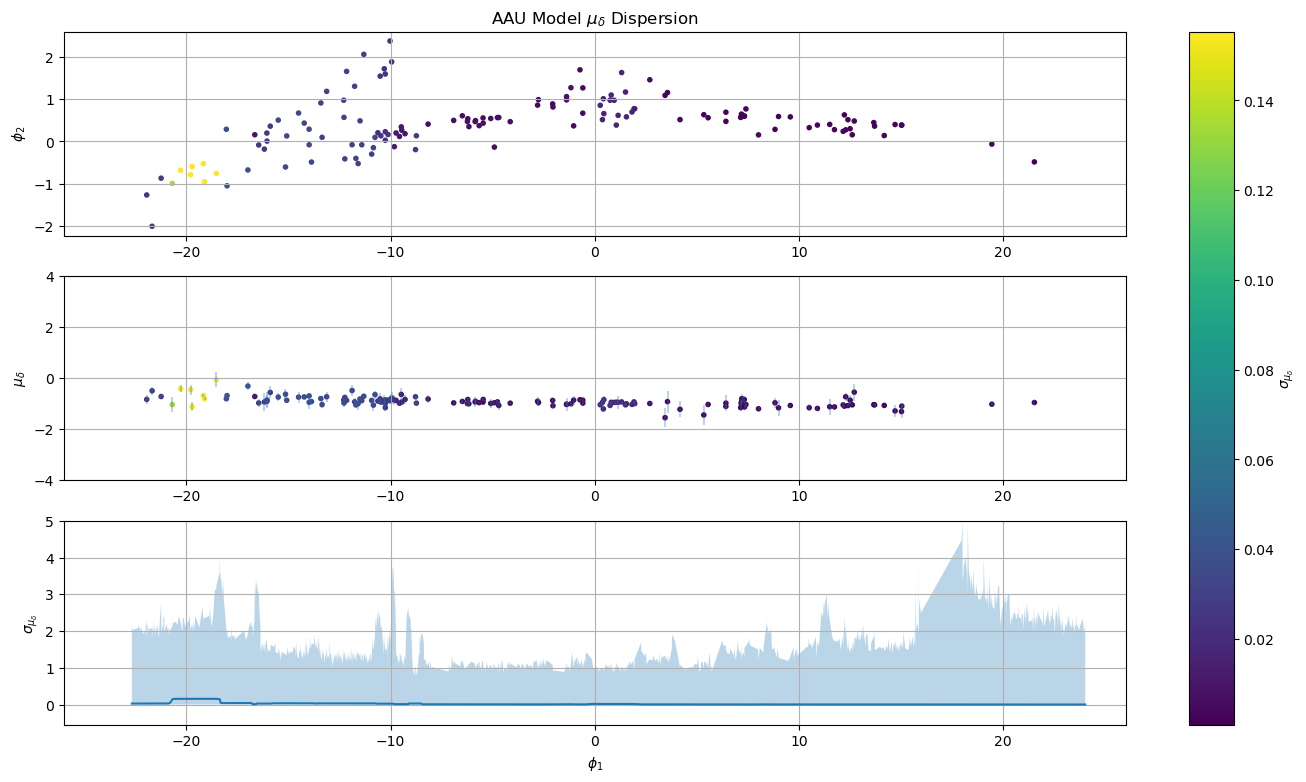

In [52]:
samples_2 = []
for i in range(len(data['phi1'])):
    hlp = []
    for j in range(100):
        hlp.append(rv_samples_mu[j][i])
    samples_2.append(np.percentile(hlp, 95)-np.percentile(hlp, 5))
samples_2 = np.array(samples_2)


# Plot Setup
fig = plt.figure(dpi=100, figsize=(9,9))

gs1 = plt.GridSpec(3, 1, left=0.05, right=1.23, wspace=0.05)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
gs2 = plt.GridSpec(1, 1, left=1.30, right=1.35, hspace=0.05)
ax4 = fig.add_subplot(gs2[0,0])

# Axes Labels
ax1.set_ylabel('$\\phi_2$')
ax2.set_ylabel('$\\mu_{\\delta}$')
ax3.set_ylabel('$\\sigma_{\\mu_{\\delta}}$')
ax3.set_xlabel('$\\phi_1$')
ax1.set_title('AAU Model $\\mu_{\\delta}$ Dispersion')

# Plotting
t1 = ax1.scatter(test['phi1'], test['phi2'], c=np.exp(mpars['stream.astrometric.pmdec', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members')
t2 = ax2.scatter(test['phi1'], test['pmdec'], c=np.exp(mpars['stream.astrometric.pmdec', 'ln-sigma'].numpy()[outp]), cmap='viridis',  marker='.', alpha=1, label='ML Model Probable Members') 
ax2.errorbar(test['phi1'].value, test['pmdec'].value, yerr=test['pmdec_error'].value, fmt='none', alpha=0.3, label='ML Model Probable Members')


ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.pmdec', 'ln-sigma']))
fig.colorbar(t1, label='$\\sigma_{\\mu_{\\delta}}$', cax=ax4, orientation='vertical')

temp = np.exp(mpars['stream.astrometric.pmdec', 'ln-sigma'])-samples_2
for i in range(len(temp)):
    if temp[i] < 0.:
        temp[i] = 0
ax3.fill_between(data['phi1'], temp, np.exp(mpars['stream.astrometric.pmdec', 'ln-sigma'])+0.5*samples_2, alpha=0.3, interpolate=True )
#ax3.plot(data['phi1'], np.exp(mpars['stream.astrometric.rv', 'ln-sigma']+0.5*abce), alpha=0.3 )
# Axis Limits and Misc.
ax1.set_xlim((-26,26))
ax2.set_xlim((-26,26))
ax3.set_xlim((-26,26))
ax2.set_ylim((-4,4))
ax3.set_ylim((-0.55,5))
ax1.grid()
ax2.grid()
ax3.grid()

In [53]:
sel = (((atlas_data_red['decam_g'].value - atlas_data_red['decam_i'].value) > -1.0) 
       & ((atlas_data_red['decam_g'].value - atlas_data_red['decam_i'].value) < 1.5))

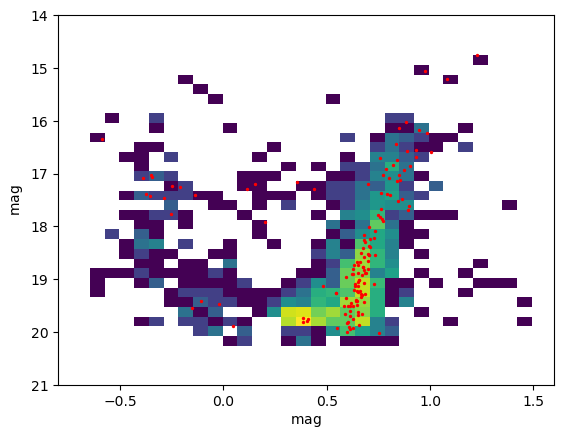

In [54]:
plt.hist2d((atlas_data_red['decam_g'] - atlas_data_red['decam_i'])[sel], atlas_data_red['decam_g'][sel],
           bins=30, label='GD-1', norm=mcl.LogNorm())
plt.xlim((-0.8,1.6))
plt.ylim((21,14))
plt.scatter(test['decam_g']-test['decam_i'], test['decam_g'], s=2, color='red')
plt.show()